# FEM Modelling for E-shaped Ferrite Core Transformer

## Import Packages

In [1]:
using gmsh
using LinearAlgebra
using LaTeXStrings
include("../../lib/Makie_Plots/Makie_Plots.jl");
using .Makie_Plots

## Julia code

Info    : Reading '../mesh/e_shaped_ferrite_core_transformer.msh'...
Info    : 75 entities
Info    : 6027 nodes
Info    : 11928 elements
Info    : Done reading '../mesh/e_shaped_ferrite_core_transformer.msh'
Contour plot of the magnetic flux density :


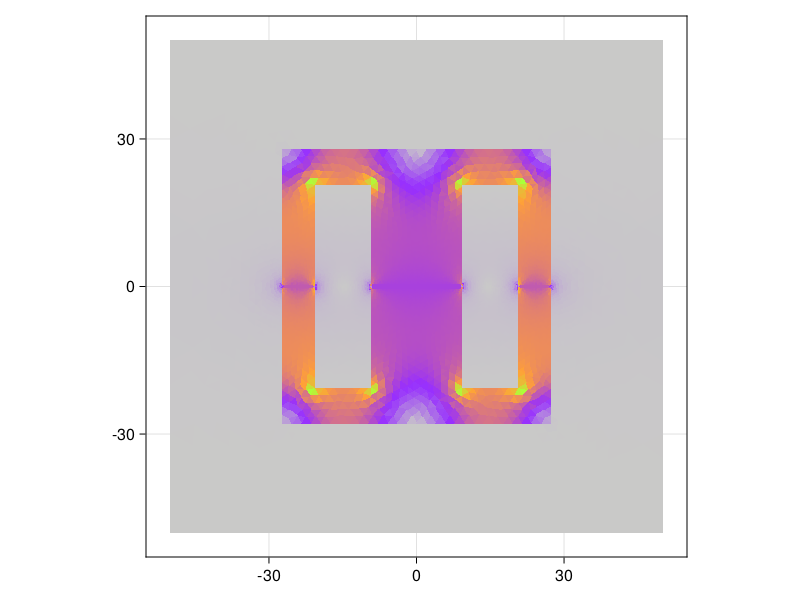

Contour plot of the magnetic field strength :


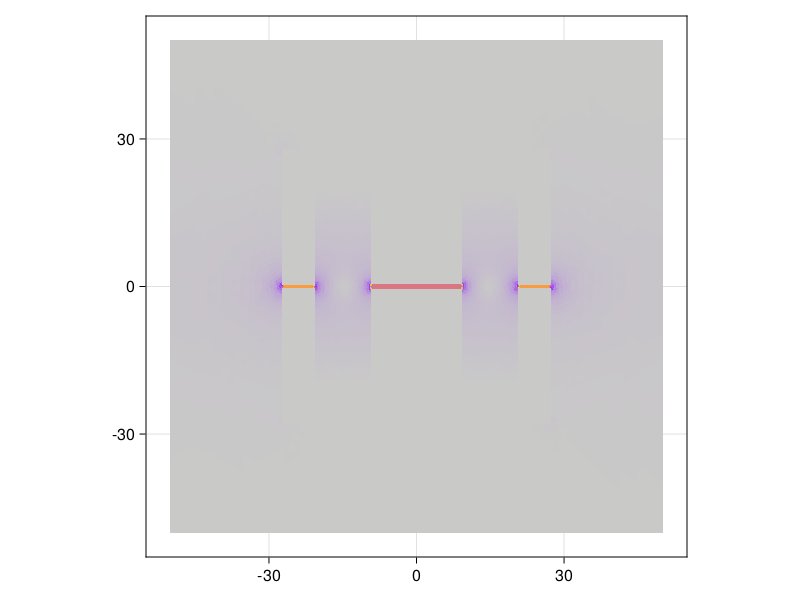

Contour plot of the magnetic energy :


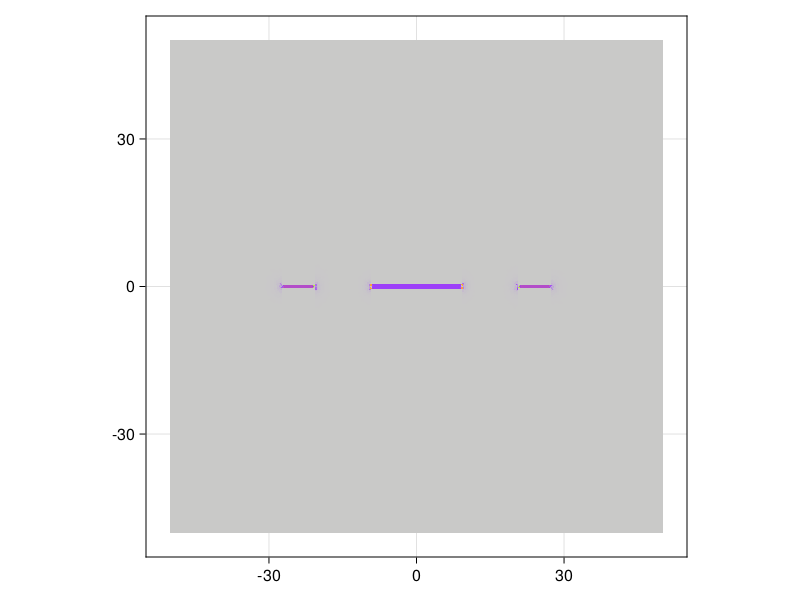

In [2]:
gmsh.initialize()

## Constants
mur = 2000;  #relative permeability of the core
mu0 = 4*pi*10^(-7);
curr_dens_value = 3.1085;
k = 0.2227

## Read mesh from file
gmsh.open("../mesh/e_shaped_ferrite_core_transformer.msh")

## Get and sort the mesh nodes
node_ids, node_coord, _ = gmsh.model.mesh.getNodes()
nnodes = length(node_ids)
#..sort the node coordinates by ID, such that Node one sits at row 1
tosort = [node_ids node_coord[1:3:end] node_coord[2:3:end]];
sorted = sortslices(tosort , dims = 1);
node_ids = sorted[:,1]
xnode = sorted[:,2]
ynode = sorted[:,3]

## Get the mesh elements
element_types, element_ids, element_connectivity = gmsh.model.mesh.getElements(2)
nelements = length(element_ids[1])

## Create groups of elements for the subdomains
ngroup1 = gmsh.model.mesh.getNodesForPhysicalGroup(2, 401)
ngroup2 = gmsh.model.mesh.getNodesForPhysicalGroup(2, 402)
ngroup3 = gmsh.model.mesh.getNodesForPhysicalGroup(2, 403)
ngroup4 = gmsh.model.mesh.getNodesForPhysicalGroup(2, 404)
ngroup5 = gmsh.model.mesh.getNodesForPhysicalGroup(2, 405)
e_group = zeros(1,nelements)
for element_id in 1:nelements
    node1_id = element_connectivity[1][3*(element_id-1)+1]
    node2_id = element_connectivity[1][3*(element_id-1)+2]
    node3_id = element_connectivity[1][3*(element_id-1)+3]
    G1 = sum(node1_id.== ngroup1[1])+sum(node2_id.== ngroup1[1])+sum(node3_id.== ngroup1[1]) #Air
    G2 = sum(node1_id.== ngroup2[1])+sum(node2_id.== ngroup2[1])+sum(node3_id.== ngroup2[1]) #upper core
    G3 = sum(node1_id.== ngroup3[1])+sum(node2_id.== ngroup3[1])+sum(node3_id.== ngroup3[1]) #lower core
    G4 = sum(node1_id.== ngroup4[1])+sum(node2_id.== ngroup4[1])+sum(node3_id.== ngroup4[1]) #winding right
    G5 = sum(node1_id.== ngroup5[1])+sum(node2_id.== ngroup5[1])+sum(node3_id.== ngroup5[1]) #winding left
    if G1 == 3
        e_group[element_id] = 1;
    elseif G2 == 3 || G3 == 3
        e_group[element_id] = 2;
    elseif G4 == 3
        e_group[element_id] = 4;
    elseif G5 == 3
        e_group[element_id] = 5;
    end
end

## Define the source function and the reluctivity function and
## And define the source function and reluctivity value for each element in the mesh using map.
sourcefunction(group_id) = curr_dens_value*(group_id==4)-curr_dens_value*(group_id==5)
sourceperelement = map(sourcefunction, e_group)
#..The reluctivity function defines the reluctivity value over the whole domain
#..The reluctivity is set equal to nu0 = 1/mu0 in the coil and air subdomains
#..The reluctivity is set equal to nu=1/mu=1/(mu0*muR) in the ferromagnetic core subdomains
reluctivityfunction(group_id) = (1/mu0)*((group_id==1)+(group_id==4)+(group_id==5))+(1/(mu0*mur))*((group_id==2))
reluctivityperelement = map(reluctivityfunction, e_group)

## initialize global matrix A and global vector f
A = zeros(nnodes,nnodes)
f = zeros(nnodes,1)
Bx = zeros(nelements,1)
By = zeros(nelements,1)
Hx = zeros(nelements,1)
Hy = zeros(nelements,1)
mag_energy = zeros(nelements,1)
x_center = zeros(nelements,1)
y_center = zeros(nelements,1)

## Perform a loop over the elements
for element_id in 1:nelements
    #....retrieve global numbering of the local nodes of the current element
    node1_id = element_connectivity[1][3*(element_id-1)+1]
    node2_id = element_connectivity[1][3*(element_id-1)+2]
    node3_id = element_connectivity[1][3*(element_id-1)+3]
    #....retrieve the x and y coordinates of the local nodes of the current element
    xnode1 = xnode[node1_id]; xnode2 = xnode[node2_id]; xnode3 = xnode[node3_id];
    ynode1 = ynode[node1_id]; ynode2 = ynode[node2_id]; ynode3 = ynode[node3_id];
    #....compute surface area of the current element
    x12 = xnode2 - xnode1; x13 = xnode3-xnode1;
    y12 = ynode2 - ynode1; y13 = ynode3-ynode1;
    area_id = x12*y13 - x13*y12; area_id = abs(area_id)/2
    #....compute local vector contribution floc of the current element
    floc = area_id/3*sourceperelement[element_id]*[1; 1; 1]
    #....compute local matrix contribution Aloc of the current element
    Emat = [[xnode1;xnode2;xnode3] [ynode1;ynode2;ynode3] [1;1;1]]\UniformScaling(1.);
    Emat[3,:] .= 0;
    Aloc = area_id*reluctivityperelement[element_id]*(transpose(Emat)*Emat);
    #....perform loop over nodes of the current element
    #....and add local contribution Aloc to global matrix entity A
    for i = 1:3
        I = element_connectivity[1][3*(element_id-1)+i]
        f[I] += floc[i]
        for j = 1:3
            J = element_connectivity[1][3*(element_id-1)+j]
            A[I,J] += Aloc[i,j]
        end
    end
end

## Handle the boundary conditions
node_ids1, node_coord, _ = gmsh.model.mesh.getNodes(0,1)
node_ids2, node_coord, _ = gmsh.model.mesh.getNodes(0,2)
node_ids3, node_coord, _ = gmsh.model.mesh.getNodes(0,3)
node_ids4, node_coord, _ = gmsh.model.mesh.getNodes(0,4)
node_ids5, node_coord, _ = gmsh.model.mesh.getNodes(1,101)
node_ids6, node_coord, _ = gmsh.model.mesh.getNodes(1,102)
node_ids7, node_coord, _ = gmsh.model.mesh.getNodes(1,103)
node_ids8, node_coord, _ = gmsh.model.mesh.getNodes(1,104)
bnd_node_ids = union(node_ids1,node_ids2,node_ids3,node_ids4,node_ids5,node_ids6,node_ids7,node_ids8)
A[bnd_node_ids,:] .= 0;
A[bnd_node_ids,bnd_node_ids] = Diagonal(ones(size(bnd_node_ids)))
f[bnd_node_ids] .= 0;

## Compute the numerical solution
u = A\f

## Perform a loop over the elements
for element_id in 1:nelements
    #....retrieve global numbering of the local nodes of the current element
    node1_id = element_connectivity[1][3*(element_id-1)+1]
    node2_id = element_connectivity[1][3*(element_id-1)+2]
    node3_id = element_connectivity[1][3*(element_id-1)+3]
    #....retrieve the x and y coordinates of the local nodes of the current element
    xnode1 = xnode[node1_id]; xnode2 = xnode[node2_id]; xnode3 = xnode[node3_id];
    ynode1 = ynode[node1_id]; ynode2 = ynode[node2_id]; ynode3 = ynode[node3_id];
    #....compute local matrix contribution Aloc of the current element
    Emat = [[xnode1;xnode2;xnode3] [ynode1;ynode2;ynode3] [1;1;1]]\UniformScaling(1.);
    Emat[3,:] .= 0;
    uloc = zeros(3,1)
    Bxloc = 0
    Byloc = 0
    for i = 1:3
        I = element_connectivity[1][3*(element_id-1)+i]
        uloc[i] = u[I]
    end
    Cmat = uloc;
    for i = 1:3
        Bxloc += Cmat[i]*Emat[2,i]
        Byloc += - Cmat[i]*Emat[1,i]
    end
    Bx[element_id] = Bxloc
    By[element_id] = Byloc
    Hx[element_id] = reluctivityperelement[element_id] * Bx[element_id];
    Hy[element_id] = reluctivityperelement[element_id] * By[element_id];
    x_center[element_id] = (xnode1 + xnode2 + xnode3)/3
    y_center[element_id] = (ynode1 + ynode2 + ynode3)/3
end

B = (Bx.^2 + By.^2).^0.5
H = (Hx.^2 + Hy.^2).^0.5

mag_energy = 0.5 .* B .* H

# println("Contour plot of the voltage distribution :")
# display(GR.tricont(xnode,ynode,u))
println("Contour plot of the magnetic flux density :")
display(plot_surface(B, gmsh))
println("Contour plot of the magnetic field strength :")
display(plot_surface(H, gmsh))
println("Contour plot of the magnetic energy :")
display(plot_surface(mag_energy, gmsh))

gmsh.finalize()